## The best classifier

We load the dataset using Pandas Library and apply the following algorithms and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import preprocessing
%matplotlib inline

#### About Dataset

This data is about past loans. The Loan_train.csv dataset includes details of 500 customers whose loan are already paid off or defaulted. It includes following fields:

Loan_status - Whether a loan is paid off on in collection

Principal - Basic principal loan amount at the

Terms - Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule

Effective_date - When the loan got originated and took effects

Due_date - Since it’s one-time payoff schedule, each loan has one single due date

Age - Age of applicant

Education - Education of applicant

Gender - The gender of applicant

### Load Data from CSV File

In [2]:
df= pd.read_csv('Loan_train.csv')
df.head()

,Loan_ID,loan_status,Principal,terms,effective_date,due_date,paid_off_time,past_due_days,age,education,Gender
0,xqd20166231,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/14/2016 19:31,NaN,45,High School or Below,male
1,xqd20168902,PAIDOFF,1000,30,9/8/2016,10/7/2016,10/7/2016 9:00,NaN,50,Bechalor,female
2,xqd20160003,PAIDOFF,1000,30,9/8/2016,10/7/2016,9/25/2016 16:58,NaN,33,Bechalor,female
3,xqd20160004,PAIDOFF,1000,15,9/8/2016,9/22/2016,9/22/2016 20:00,NaN,27,college,male
4,xqd20160005,PAIDOFF,1000,30,9/9/2016,10/8/2016,9/23/2016 21:36,NaN,28,college,female


In [3]:
df.shape

(500, 11)

## Convert to date time object and remove columns 

In [4]:
df['effective_date']=pd.to_datetime(df['effective_date'])

In [5]:
df['due_date']= pd.to_datetime(df['due_date'])

In [6]:
df['paid_off_time'] = pd.to_datetime(df['paid_off_time'])

In [7]:
df.drop(['past_due_days','Loan_ID'],axis=1,inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,paid_off_time,age,education,Gender
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-14 19:31:00,45,High School or Below,male
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-10-07 09:00:00,50,Bechalor,female
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-25 16:58:00,33,Bechalor,female
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,2016-09-22 20:00:00,27,college,male
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,2016-09-23 21:36:00,28,college,female


## Data visualization and pre-processing

In [8]:
df['loan_status'].value_counts()

PAIDOFF               300
COLLECTION            100
COLLECTION_PAIDOFF    100
Name: loan_status, dtype: int64

here, 300 people have paid off the loan on time while 100 have gone into collection and other 100 people gone into collection paid off that means that was past due and then was paid 

Lets plot some columns to understand data better:

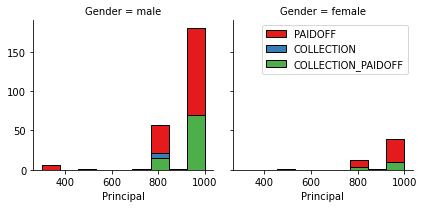

In [9]:
bins = np.linspace(df.Principal.min(),df.Principal.max(),10)
g=sns.FacetGrid(df, col='Gender',hue='loan_status',palette='Set1',col_wrap=2)
g.map(plt.hist,'Principal',bins=bins, ec = 'k')
g.axes[-1].legend()
plt.show()

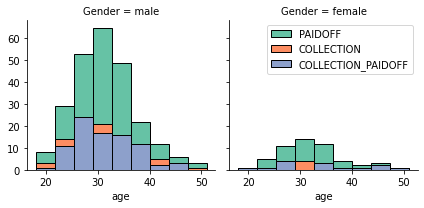

In [10]:
bins=np.linspace(df.age.min(),df.age.max(),10)
g=sns.FacetGrid(df, col='Gender', hue='loan_status',palette='Set2',col_wrap=2)
g.map(plt.hist, 'age' , bins=bins, ec='k')
g.axes[-1].legend()

### Pre-Processing: Feature Selection/Extraction

In [11]:
df['dayofweek']=df['effective_date'].dt.dayofweek

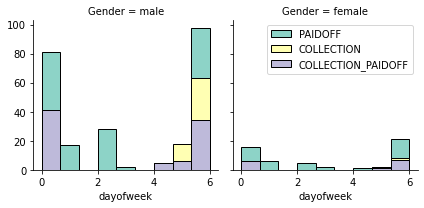

In [12]:
bins=np.linspace(df.dayofweek.min(),df.dayofweek.max(),10)
g=sns.FacetGrid(df,col='Gender',hue='loan_status',palette='Set3',col_wrap=2)
g.map(plt.hist,'dayofweek',ec='k', bins=bins)
g.axes[-1].legend()

we can see that people who get the loan at the end of the week don't pay it off, so lets use Feture binarization to set a thresold values less then day 4

In [13]:
df['weekend']=df['dayofweek'].apply(lambda x: 1 if (x<3) else 0)
df.head()

,loan_status,Principal,terms,effective_date,due_date,paid_off_time,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-14 19:31:00,45,High School or Below,male,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-10-07 09:00:00,50,Bechalor,female,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-25 16:58:00,33,Bechalor,female,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,2016-09-22 20:00:00,27,college,male,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,2016-09-23 21:36:00,28,college,female,4,0


### Convert Categorical features to numerical values

Lets Look at Gender:

In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status       
female  PAIDOFF               0.688312
        COLLECTION_PAIDOFF    0.181818
        COLLECTION            0.129870
male    PAIDOFF               0.583924
        COLLECTION            0.212766
        COLLECTION_PAIDOFF    0.203310
Name: loan_status, dtype: float64

68% female pay there loans while only 58% of males pay there loan and due payment is paid by 18% of female and 20% of male 

In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,loan_status,Principal,terms,effective_date,due_date,paid_off_time,age,education,Gender,dayofweek,weekend
0,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-14 19:31:00,45,High School or Below,0,3,0
1,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-10-07 09:00:00,50,Bechalor,1,3,0
2,PAIDOFF,1000,30,2016-09-08,2016-10-07,2016-09-25 16:58:00,33,Bechalor,1,3,0
3,PAIDOFF,1000,15,2016-09-08,2016-09-22,2016-09-22 20:00:00,27,college,0,3,0
4,PAIDOFF,1000,30,2016-09-09,2016-10-08,2016-09-23 21:36:00,28,college,1,4,0


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status       
Bechalor              PAIDOFF               0.611940
                      COLLECTION_PAIDOFF    0.223881
                      COLLECTION            0.164179
High School or Below  PAIDOFF               0.588517
                      COLLECTION            0.234450
                      COLLECTION_PAIDOFF    0.177033
Master or Above       PAIDOFF               0.750000
                      COLLECTION            0.250000
college               PAIDOFF               0.604545
                      COLLECTION_PAIDOFF    0.218182
                      COLLECTION            0.177273
Name: loan_status, dtype: float64

### Feture before One Hot Encoding

In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,50,1,Bechalor
2,1000,30,33,1,Bechalor
3,1000,15,27,0,college
4,1000,30,28,1,college


### Use One hot encoding technique to cover categorical variables to binary variables and append them to the feature Data Frame

In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,50,1,0,1,0,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,0,0,0,1


### Feature Selection

Lets define feature sets X:

In [19]:
X=Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,50,1,0,1,0,0
2,1000,30,33,1,0,1,0,0
3,1000,15,27,0,0,0,0,1
4,1000,30,28,1,0,0,0,1


What are our lables??

In [20]:
y=df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

### Normalize data

Data Standardization give data zero mean and unit variance(technically should be done after train test split)

In [21]:
X=preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49337687,  0.89789115,  2.28404253, -0.42665337, -0.83017419,
        -0.39336295,  1.17997648, -0.88640526],
       [ 0.49337687,  0.89789115,  3.10658738,  2.34382305, -0.83017419,
         2.54218146, -0.84747452, -0.88640526],
       [ 0.49337687,  0.89789115,  0.3099349 ,  2.34382305, -0.83017419,
         2.54218146, -0.84747452, -0.88640526],
       [ 0.49337687, -0.97897162, -0.67711892, -0.42665337, -0.83017419,
        -0.39336295, -0.84747452,  1.12815215],
       [ 0.49337687,  0.89789115, -0.51260995,  2.34382305, -0.83017419,
        -0.39336295, -0.84747452,  1.12815215]])

## Classification

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model You should use the following algorithm:

K Nearest Neighbor(KNN)

Decision Tree

Support Vector Machine

Logistic Regression

#### Notice:

You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.

You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.

You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)

Notice:
You should find the best k to build the model with the best accuracy.

#### Warning: 
You should not use the loan_test.csv for finding the best k, however, you can split your train_loan.csv into train and test to find the best k.

In [22]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=4)
print("Train Set: ",X_train.shape, y_train.shape)
print("Test Set: ",X_test.shape,y_test.shape)

Train Set:  (350, 8) (350,)
Test Set:  (150, 8) (150,)


In [23]:
from sklearn.neighbors import KNeighborsClassifier
k = 22

neighK22 = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neighK22
 
yhat = neighK22.predict(X_test)
yhat[0:5]

from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neighK22.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.6057142857142858
Test set Accuracy:  0.6066666666666667


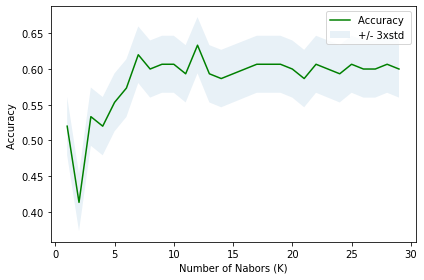

Best accuracy: 0.6333333333333333 k= 12


In [24]:
Ks = 30
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

ConfustionMx = [];
for n in range(1,Ks):
    
    
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()
print( "Best accuracy:", mean_acc.max(), "k=", mean_acc.argmax()+1)

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
X_trainset,X_testset,y_trainset,y_testset=train_test_split(X,y,test_size=0.3,random_state=4)
## Modelling
Tree=DecisionTreeClassifier(criterion='entropy',max_depth=6)
Tree


DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [26]:
Tree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=6)

In [27]:
predTree = Tree.predict(X_testset)
print (predTree [0:5])
print (y_testset [0:5])

from sklearn import metrics
import matplotlib.pyplot as plt

print("Accuracy: ", metrics.accuracy_score(y_testset, predTree))



['PAIDOFF' 'PAIDOFF' 'COLLECTION' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
Accuracy:  0.54


In [ ]:
!conda install -c conda-forge pydotplus -y
!conda install -c conda-forge python-graphviz -y

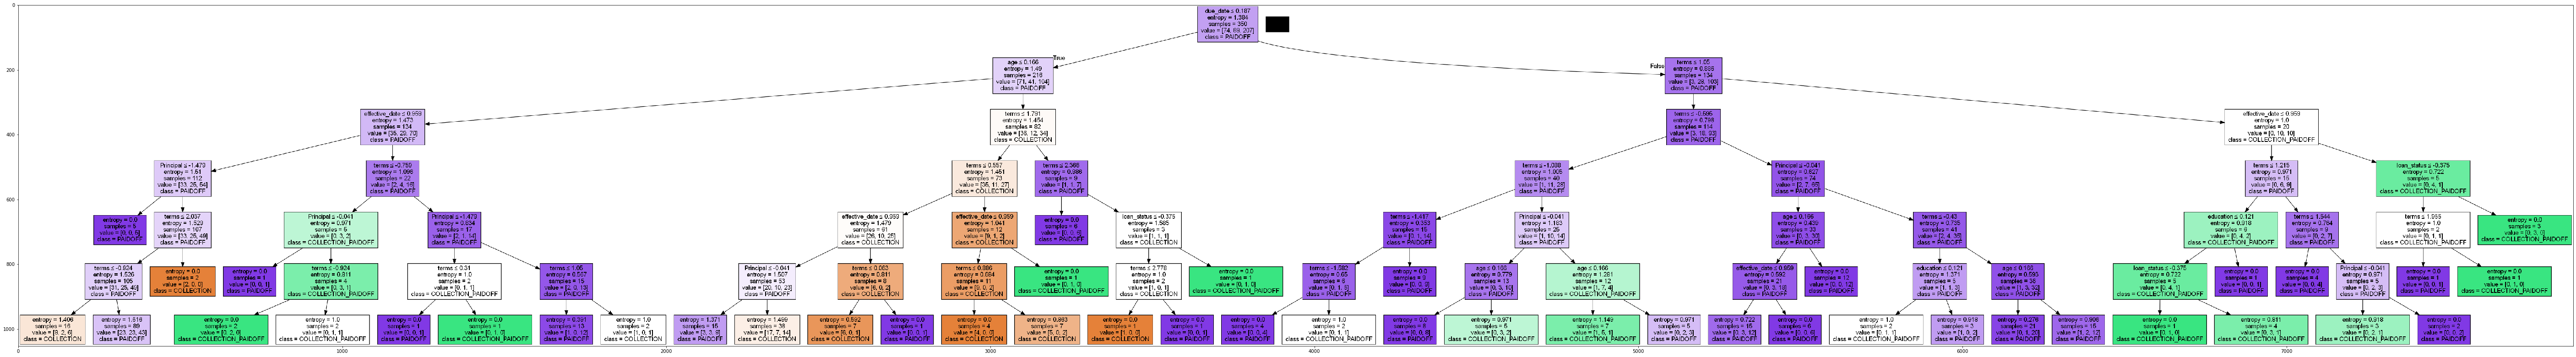

In [28]:
from six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 
dot_data = StringIO()
filename = "loan.png"
featureNames = df.columns[0:8]
targetNames = df['loan_status'].unique().tolist()
out=tree.export_graphviz(Tree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

# Suport vector machine

In [29]:
df.dtypes
df = df[pd.to_numeric(df['education'], errors='coerce').notnull()]
df['education'] = df['education'].astype('int')
df.dtypes

from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train)

SVC()

In [30]:
yhat = clf.predict(X_test)
yhat [0:5]
from sklearn.metrics import classification_report, confusion_matrix
import itertools

                    precision    recall  f1-score   support

        COLLECTION       0.25      0.17      0.20        18
COLLECTION_PAIDOFF       0.00      0.00      0.00        16
           PAIDOFF       0.67      0.89      0.77        66

          accuracy                           0.62       100
         macro avg       0.31      0.35      0.32       100
      weighted avg       0.49      0.62      0.54       100



C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\

0.4492753623188406

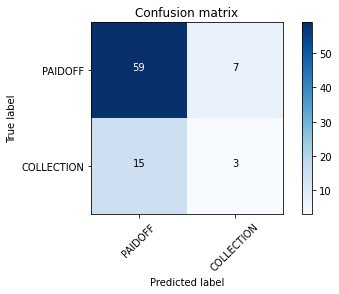

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
cnf_matrix = confusion_matrix(y_test, yhat, labels=['PAIDOFF','COLLECTION'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['PAIDOFF','COLLECTION'],normalize= False,  title='Confusion matrix')

from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted')

from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat, pos_label='positive',average='micro')

# Logistic Regression

In [41]:
df=df[['loan_status','Principal','terms','effective_date', 'due_date', 'age', 'education', 'Gender']]
df['loan_status'] = df['loan_status'].astype('int')

from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.49,  0.9 ,  2.28, -0.43, -0.83, -0.39,  1.18, -0.89],
       [ 0.49,  0.9 ,  3.11,  2.34, -0.83,  2.54, -0.85, -0.89],
       [ 0.49,  0.9 ,  0.31,  2.34, -0.83,  2.54, -0.85, -0.89],
       [ 0.49, -0.98, -0.68, -0.43, -0.83, -0.39, -0.85,  1.13],
       [ 0.49,  0.9 , -0.51,  2.34, -0.83, -0.39, -0.85,  1.13]])

In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (400, 8) (400,)
Test set: (100, 8) (100,)


In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LogR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LogR


LogisticRegression(C=0.01, solver='liblinear')

In [53]:
yhat = LogR.predict(X_test)
yhat
yhat_prob = LogR.predict_proba(X_test)
yhat_prob

array([[0.32, 0.3 , 0.37],
       [0.15, 0.25, 0.61],
       [0.32, 0.28, 0.4 ],
       [0.21, 0.31, 0.48],
       [0.3 , 0.27, 0.43],
       [0.35, 0.27, 0.37],
       [0.37, 0.28, 0.34],
       [0.38, 0.28, 0.34],
       [0.34, 0.3 , 0.37],
       [0.35, 0.27, 0.37],
       [0.33, 0.3 , 0.37],
       [0.22, 0.31, 0.47],
       [0.29, 0.26, 0.45],
       [0.22, 0.31, 0.48],
       [0.23, 0.28, 0.49],
       [0.22, 0.27, 0.51],
       [0.38, 0.28, 0.34],
       [0.34, 0.28, 0.39],
       [0.25, 0.3 , 0.45],
       [0.24, 0.28, 0.48],
       [0.24, 0.28, 0.48],
       [0.34, 0.26, 0.41],
       [0.35, 0.28, 0.37],
       [0.22, 0.31, 0.47],
       [0.32, 0.28, 0.4 ],
       [0.22, 0.3 , 0.48],
       [0.34, 0.3 , 0.37],
       [0.24, 0.28, 0.48],
       [0.34, 0.25, 0.41],
       [0.21, 0.29, 0.5 ],
       [0.37, 0.28, 0.34],
       [0.25, 0.23, 0.53],
       [0.37, 0.28, 0.34],
       [0.34, 0.25, 0.41],
       [0.3 , 0.29, 0.41],
       [0.37, 0.28, 0.34],
       [0.22, 0.31, 0.48],
 

In [47]:
from sklearn.metrics import jaccard_score
jaccard_score(y_test, yhat,pos_label='positive',average='micro')
from sklearn.metrics import log_loss
log_loss(y_test, yhat_prob)

C:\Users\DEll\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1379: UserWarning: Note that pos_label (set to 'positive') is ignored when average != 'binary' (got 'micro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(


0.948009369504095